# **WQU ML Handbook 3**

GROUP WORK PROJECT # 3 \\
MScFE 632: Machine Learning in Finance \\
GROUP NUMBER: 2722 \\

## Computation and Technical Section

## $\underline{Issue \ 1: \  Optimizing \ the \ Hyperparameters}$ By Chen Jian Hui

Information about the input dataset - Predict whether income exceeds $50K/yr based on census data

The dataset used is US Census data which is an extraction of the 1994 census data which was donated to the UC Irvine’s Machine Learning Repository. The data contains approximately 32,000 observations with over 15 variables. The dependent variable in our analysis will be income level and who earns above $50,000 a year

In [1]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# general 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For execution time
import time

# Machine Learning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# Ignoring warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Load the loan data
colnames=['age', 'workclass', 'fnlwgt', 'education','education_num', 'marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','target'] 


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Adult Data.csv to Adult Data.csv


In [5]:
import io
data = pd.read_csv(io.BytesIO(uploaded['Adult Data.csv']), names=colnames, header=None, index_col=False)
# Dataset is now stored in a Pandas Dataframe

data['target'] = np.where(data.target == ' <=50K', 0, 1)

In [6]:
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [7]:
data.target.value_counts()

0    24720
1     7841
Name: target, dtype: int64

In [8]:
#select 4 features for demonstration
features = ['age','education_num','sex','hours_per_week']
all_ft = features + ['target']
df = data[all_ft]

In [9]:
print([column for column in df.columns if df[column].dtype == object])

['sex']


In [10]:
df.sex.value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [11]:
# convert categorical
df['sex'] = np.where(df['sex'] == ' Male', 1, 0)
df.sex.value_counts()

1    21790
0    10771
Name: sex, dtype: int64

In [12]:
df.head()

,age,education_num,sex,hours_per_week,target
0,39,13,1,40,0
1,50,13,1,13,0
2,38,9,1,40,0
3,53,7,1,40,0
4,28,13,0,40,0


In [20]:
# Select the features and target variable
X = df.drop(['target'], axis=1)
y = df['target']

In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
# Grid Search

# get the start time
st_gs = time.time()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [2, 5]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1)
grid_search.fit(X_train, y_train)

# get the end time
et_gs = time.time()

# get the execution time
elapsed_time_gs = et_gs - st_gs

print("GRID SEARCH")
print("Optimal hyperparameters: ", grid_search.best_params_)
print("Best score: ", round(grid_search.best_score_,5))
print('Execution time for GridSearch:', round(elapsed_time_gs,2), 'seconds')

GRID SEARCH
Optimal hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200}
Best score:  0.81012
Execution time for GridSearch: 89.35 seconds


In [23]:
# Random Search
np.random.seed(0)

# get the start time
st_rs = time.time()

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None,3, 5],
    'min_samples_leaf': randint(2, 5)
}

rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, cv = 3, n_iter = 10, n_jobs = -1)
random_search.fit(X_train, y_train)

# get the end time
et_rs = time.time()

# get the execution time
elapsed_time_rs = et_rs - st_rs

print("RANDOM SEARCH")
print("Optimal hyperparameters: ", random_search.best_params_)
print("Best score: ", round(random_search.best_score_,5))
print('Execution time:', round(elapsed_time_rs,2), 'seconds')

RANDOM SEARCH
Optimal hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 188}
Best score:  0.80974
Execution time: 53.84 seconds


In [24]:
#Bayesian Optimization

# get the start time
st_bo = time.time()

search_spaces = {'n_estimators': Integer(100, 300),
                 'max_depth': Integer(1, 5),
                 'min_samples_leaf': Integer(2, 5)}

rf = RandomForestClassifier()
bayes_search = BayesSearchCV(rf, search_spaces, cv=5, n_iter=20, random_state=0)
bayes_search.fit(X_train, y_train)

# get the end time
et_bo = time.time()

# get the execution time
elapsed_time_bo = et_bo - st_bo

print("BAYESIAN OPTIMIZATION")
print("Optimal hyperparameters: ", bayes_search.best_params_)
print("Best score: ", round(bayes_search.best_score_,5))
print('Execution time:', round(elapsed_time_bo,2), 'seconds')

BAYESIAN OPTIMIZATION
Optimal hyperparameters:  OrderedDict([('max_depth', 4), ('min_samples_leaf', 5), ('n_estimators', 247)])
Best score:  0.80951
Execution time: 184.42 seconds


In [25]:
# Generating predictions and probabilities for each method

# GRID SEARCH
grid_search_pred = grid_search.predict(X_test)
grid_search_pred_prob_temp = grid_search.predict_proba(X_test)
grid_search_pred_prob = grid_search_pred_prob_temp[:,1]

# RANDOM SEARCH
random_search_pred = random_search.predict(X_test)
random_search_pred_prob_temp = random_search.predict_proba(X_test)
random_search_pred_prob = random_search_pred_prob_temp[:,1]

# Bayesian Optimization
bayes_opt_pred = grid_search.predict(X_test)
bayes_opt_pred_prob_temp = grid_search.predict_proba(X_test)
bayes_opt_pred_prob = bayes_opt_pred_prob_temp[:,1]

No Skill: ROC AUC=0.50000
RFC with grid search: ROC AUC=0.82674
RFC with random search: ROC AUC=0.82751
RFC with Bayesian Optimization: ROC AUC=0.82674


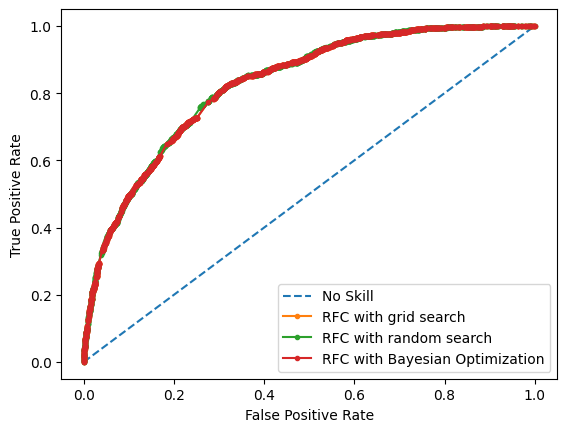

In [26]:
# Plotting the roc curve and AUC score for each model
# ROC curve
fpr_gs, tpr_gs, _ = roc_curve(y_test, grid_search_pred_prob) # Grid Search
fpr_rs, tpr_rs, _ = roc_curve(y_test, random_search_pred_prob) # Random Search
fpr_bo, tpr_bo, _ = roc_curve(y_test, bayes_opt_pred_prob) # Bayesian Optimization

# generate a no skill prediction
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# AUC Score
ns_auc = roc_auc_score(y_test, ns_probs)  # no-skill
gs_auc = roc_auc_score(y_test, grid_search_pred_prob)  # Grid Search
rs_auc = roc_auc_score(y_test, random_search_pred_prob)  # Random Search
bo_auc = roc_auc_score(y_test, bayes_opt_pred_prob)  # Bayesian Optimization

# summarize scores
print("No Skill: ROC AUC=%.5f" % (ns_auc))
print("RFC with grid search: ROC AUC=%.5f" % (gs_auc))
print("RFC with random search: ROC AUC=%.5f" % (rs_auc))
print("RFC with Bayesian Optimization: ROC AUC=%.5f" % (bo_auc))

plt.plot(ns_fpr, ns_tpr, linestyle="--", label="No Skill")
plt.plot(fpr_gs, tpr_gs, marker=".", label="RFC with grid search")
plt.plot(fpr_rs, tpr_rs, marker=".", label="RFC with random search")
plt.plot(fpr_bo, tpr_bo, marker=".", label="RFC with Bayesian Optimization")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# show the legend
plt.legend()

# show the plot
plt.show();

## $\underline{Issue \ 3: \  Applying \ Ensemble \ Learning}$ By Win Htet


For this issue, we will be using the dataset of Luxembourg with other indices provided in WQU ML course for practice as the reference.



In [27]:
# Import Necessary Libraries for Machine Learning
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb

In [28]:
from google.colab import files
uploaded = files.upload()

Saving ml_practice_LUXXX.csv to ml_practice_LUXXX.csv


In [29]:
import io
data = pd.read_csv(io.BytesIO(uploaded['ml_practice_LUXXX.csv']))
# Dataset is now stored in a Pandas Dataframe

In [30]:
# Noting that Date is regarded as object, we will change it back into date time
data["Date"] = pd.to_datetime(data.iloc[:,1])
data_df = data.drop(data.columns[[0, 1]],axis = 1)
data_df.head()

,LUXXX,MSCI ARGENTINA,BLP ORIENTE MEDIO,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHINA,MSCI DENMARK,...,MSCI PERU,MSCI RUSSIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI UK,MSCI USA,Date
0,1390.716,2376.29,3525.9150,1068.79,106.70,105.38,1036.23,1663.27,59.47,8566.71,...,811.96,404.73,1507.8101,1255.75,108.40,11136.65,1148.37,1818.40,1949.70,2016-01-01
1,1291.267,2260.85,3280.6683,1005.56,97.66,99.35,952.01,1586.18,54.63,8183.00,...,751.09,388.05,1437.6600,1177.76,101.00,10389.93,1075.30,1722.00,1831.88,2016-01-08
2,1257.086,2217.50,3118.2981,985.38,93.54,97.32,904.64,1541.08,51.54,7755.73,...,720.23,344.45,1372.9800,1133.72,97.34,10042.32,1056.01,1692.43,1789.56,2016-01-15
3,1254.167,2281.98,2935.0677,985.87,95.79,100.73,879.17,1582.10,51.15,8035.69,...,745.96,367.44,1350.0500,1160.48,99.21,10469.07,1076.48,1719.61,1814.12,2016-01-22
4,1298.240,2462.19,3134.0840,1005.56,96.93,103.05,958.97,1638.84,52.13,8211.17,...,825.18,400.93,1375.1000,1239.58,100.06,10432.42,1087.17,1774.40,1843.88,2016-01-29


In [31]:
# Changing Date column to the left
cols_change = data_df.columns.tolist()
cols_change = cols_change[-1:] + cols_change[:-1]
data_df = data_df[cols_change]
data_df.head()

,Date,LUXXX,MSCI ARGENTINA,BLP ORIENTE MEDIO,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHINA,...,MSCI NORWAY,MSCI PERU,MSCI RUSSIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI UK,MSCI USA
0,2016-01-01,1390.716,2376.29,3525.9150,1068.79,106.70,105.38,1036.23,1663.27,59.47,...,2373.17,811.96,404.73,1507.8101,1255.75,108.40,11136.65,1148.37,1818.40,1949.70
1,2016-01-08,1291.267,2260.85,3280.6683,1005.56,97.66,99.35,952.01,1586.18,54.63,...,2209.38,751.09,388.05,1437.6600,1177.76,101.00,10389.93,1075.30,1722.00,1831.88
2,2016-01-15,1257.086,2217.50,3118.2981,985.38,93.54,97.32,904.64,1541.08,51.54,...,2095.60,720.23,344.45,1372.9800,1133.72,97.34,10042.32,1056.01,1692.43,1789.56
3,2016-01-22,1254.167,2281.98,2935.0677,985.87,95.79,100.73,879.17,1582.10,51.15,...,2173.55,745.96,367.44,1350.0500,1160.48,99.21,10469.07,1076.48,1719.61,1814.12
4,2016-01-29,1298.240,2462.19,3134.0840,1005.56,96.93,103.05,958.97,1638.84,52.13,...,2214.88,825.18,400.93,1375.1000,1239.58,100.06,10432.42,1087.17,1774.40,1843.88


In [32]:
# Set Target Index for predicting
target_ETF = "LUXXX"

# Use returns instead of prices for other Indices
# Other Indices used as Index_features
ETF_features = data_df.loc[:, ~data_df.columns.isin(["Date", target_ETF])].columns
data_df[ETF_features] = data_df[ETF_features].pct_change()

data_df[target_ETF + "_returns"] = data_df[target_ETF].pct_change()

# Create Target Column.
# Shift period for target column
data_df[target_ETF + "_returns" + "_Shift"] = data_df[target_ETF + "_returns"].shift(-1)

# Strategy to take long position for anticipated returns of 2.5%
data_df["Target"] = np.where(
    (data_df[target_ETF + "_returns_Shift"].abs() > 0.025), 1, 0
)

In [33]:
# Four country indices used. This time we used different countries
feats = ["MSCI CHINA", "MSCI SINGAPORE", "MSCI RUSSIA", "MSCI DENMARK", "MSCI NORWAY"]

# creating the technical indicators
data_df["SMA_5"] = data_df[target_ETF].rolling(5).mean()
data_df["SMA_15"] = data_df[target_ETF].rolling(15).mean()
data_df["SMA_ratio"] = data_df["SMA_15"] / data_df["SMA_5"]

# Can drop SMA columns since not needed anymore.
data_df.drop(["SMA_5", "SMA_15"], axis=1, inplace=True)

# shift the price of the target by 1 unit previous in time
data_df["Diff"] = data_df[target_ETF] - data_df[target_ETF].shift(1)
data_df["Up"] = data_df["Diff"]
data_df.loc[(data_df["Up"] < 0), "Up"] = 0

data_df["Down"] = data_df["Diff"]
data_df.loc[(data_df["Down"] > 0), "Down"] = 0
data_df["Down"] = abs(data_df["Down"])

data_df["avg_5up"] = data_df["Up"].rolling(5).mean()
data_df["avg_5down"] = data_df["Down"].rolling(5).mean()

data_df["avg_15up"] = data_df["Up"].rolling(15).mean()
data_df["avg_15down"] = data_df["Down"].rolling(15).mean()

data_df["RS_5"] = data_df["avg_5up"] / data_df["avg_5down"]
data_df["RS_15"] = data_df["avg_15up"] / data_df["avg_15down"]

data_df["RSI_5"] = 100 - (100 / (1 + data_df["RS_5"]))
data_df["RSI_15"] = 100 - (100 / (1 + data_df["RS_15"]))

data_df["RSI_ratio"] = data_df["RSI_5"] / data_df["RSI_15"]

# Can drop RS Calc columns columns
data_df.drop(
    ["Diff", "Up", "Down", "avg_5up", "avg_5down", "avg_15up", "avg_15down"],
    axis=1,
    inplace=True,
)

data_df["RC"] = data_df[target_ETF].pct_change(periods=15)

# all_feats
feats.append("SMA_ratio")
feats.append("RSI_ratio")
feats.append("RC")

In [34]:
data_df["Target"].value_counts()

0    165
1     87
Name: Target, dtype: int64

In [35]:
data_df.head()

,Date,LUXXX,MSCI ARGENTINA,BLP ORIENTE MEDIO,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHINA,...,LUXXX_returns,LUXXX_returns_Shift,Target,SMA_ratio,RS_5,RS_15,RSI_5,RSI_15,RSI_ratio,RC
0,2016-01-01,1390.716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.071509,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-08,1291.267,-0.048580,-0.069555,-0.059160,-0.084724,-0.057221,-0.081275,-0.046348,-0.081386,...,-0.071509,-0.026471,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-15,1257.086,-0.019174,-0.049493,-0.020068,-0.042187,-0.020433,-0.049758,-0.028433,-0.056562,...,-0.026471,-0.002322,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-22,1254.167,0.029078,-0.058760,0.000497,0.024054,0.035039,-0.028155,0.026618,-0.007567,...,-0.002322,0.035141,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-29,1298.240,0.078971,0.067806,0.019972,0.011901,0.023032,0.090767,0.035864,0.019159,...,0.035141,-0.018185,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ensemble Learning (Bagging vs Boosting vs Stacking)

In [36]:
# Train/Test split 80/20
# Train/Test split. No NaNs in the data.
new_df = data_df.dropna()
X = new_df[feats]

X = X.iloc[:, :]  # .values
y = new_df.loc[:, "Target"]  # .values

del new_df

# from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [37]:
# parameters for AdaBoost
param_grid = {"n_estimators": [10, 20, 50, 100], "learning_rate": [0.1, 0.25, 0.5, 1.0]}

gridAdBoost = GridSearchCV(
    AdaBoostClassifier(), param_grid, refit=True, verbose=3, cv=3
)
# fitting the model for grid search
gridAdBoost.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.1, n_estimators=10;, score=0.698 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=10;, score=0.698 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=10;, score=0.710 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=20;, score=0.714 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=20;, score=0.698 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=20;, score=0.694 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.698 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.698 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=0.694 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.635 total time=   0.2s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.683 total time=   0.2s
[CV 3/3] END learning_rate=0.1, n_estimators=1

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 1.0],
                         'n_estimators': [10, 20, 50, 100]},
             verbose=3)

In [38]:
# print best parameter after tuning
print(gridAdBoost.best_params_)

# print how our AdaBoost model looks after hyper-parameter tuning
print(gridAdBoost.best_estimator_)

{'learning_rate': 0.25, 'n_estimators': 10}
AdaBoostClassifier(learning_rate=0.25, n_estimators=10)


In [39]:
# parameters for Gradient Boosting Classifier
param_grid = {"n_estimators": [10, 20, 50, 100], "learning_rate": [0.1, 0.25, 0.5, 1.0]}

GBgrid = GridSearchCV(
    GradientBoostingClassifier(), param_grid, refit=True, verbose=3, cv=3
)

# fitting the model for grid search
GBgrid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.1, n_estimators=10;, score=0.714 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=10;, score=0.651 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=10;, score=0.677 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=20;, score=0.730 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=20;, score=0.667 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=20;, score=0.645 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.667 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.683 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=0.645 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.603 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.635 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=1

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 1.0],
                         'n_estimators': [10, 20, 50, 100]},
             verbose=3)

In [40]:
# print best parameter after tuning
print(GBgrid.best_params_)

# print how our Gradient Boost model looks after hyper-parameter tuning
print(GBgrid.best_estimator_)

{'learning_rate': 0.1, 'n_estimators': 10}
GradientBoostingClassifier(n_estimators=10)


In [41]:
# parameters for XG Boosting Classifier
param_grid = {"n_estimators": [10, 20, 50, 100], "learning_rate": [0.1, 0.25, 0.5, 1.0]}

XGB_model = xgb.XGBClassifier()
XGBgrid = GridSearchCV(XGB_model, param_grid, refit=True, verbose=3, cv=3)

# fitting the model for grid search
XGBgrid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.1, n_estimators=10;, score=0.635 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=10;, score=0.683 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=10;, score=0.645 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=20;, score=0.651 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=20;, score=0.651 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=20;, score=0.661 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.651 total time=   0.0s
[CV 2/3] END learning_rate=0.1, n_estimators=50;, score=0.683 total time=   0.0s
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=0.629 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.635 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.667 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=1

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 1.0],
                         'n_estimators': [10, 20, 50, 100]},
             verbose=3)

In [42]:
# print best parameter after tuning
print(XGBgrid.best_params_)

# print how our XGBoost model looks after hyper-parameter tuning
print(XGBgrid.best_estimator_)

{'learning_rate': 0.25, 'n_estimators': 50}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [43]:
# defining parameter range
param_grid = {
    "n_estimators": [5, 10, 20],
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 4, 8],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=8), param_grid, refit=True, verbose=3, cv=3
)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=2, min_samples_split=2, n_estimators=5;, score=0.698 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=2, n_estimators=5;, score=0.683 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=2, n_estimators=5;, score=0.645 total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.698 total time=   0.0s
[CV 2/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.698 total time=   0.0s
[CV 3/3] END max_depth=2, min_samples_split=2, n_estimators=10;, score=0.677 total time=   0.0s
[CV 1/3] END max_depth=2, min_samples_split=2, n_estimators=20;, score=0.698 total time=   0.1s
[CV 2/3] END max_depth=2, min_samples_split=2, n_estimators=20;, score=0.683 total time=   0.1s
[CV 3/3] END max_depth=2, min_samples_split=2, n_estimators=20;, score=0.677 total time=   0.1s
[CV 1/3] END max_depth=2, min_samples_split=4, n_estimators=5;, score=0.698 t

In [44]:
# Train with Tuned Random Forest
# Create a tuned RF Classifier
bagmodel_tuned = RandomForestClassifier(
    max_depth=grid.best_params_["max_depth"], min_samples_split=grid.best_params_["min_samples_split"], n_estimators=grid.best_params_["n_estimators"], random_state=0
)

bagmodel_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators=10,
                       random_state=0)

In [45]:
# Stacking Model

clf1 = DecisionTreeClassifier()  # Decision Tree

clf2 = SVC(kernel="rbf")  # Support Vector Classifier

clf3 = GaussianNB()  # Gaussian Naive Bayes

est_rs = [("DTree", clf1), ("SVM", clf2), ("NB", clf3)]
# Meta model
mylr = LogisticRegression()
# creating a stacking classifier
stackingCLF = StackingClassifier(
    estimators=est_rs, final_estimator=mylr, stack_method="auto", cv=3
)
stackingCLF.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('DTree', DecisionTreeClassifier()),
                               ('SVM', SVC()), ('NB', GaussianNB())],
                   final_estimator=LogisticRegression())

In [46]:
# Create a tuned AdaBoost Classifier
AdaBoost_tuned = AdaBoostClassifier(learning_rate=gridAdBoost.best_params_["learning_rate"], n_estimators=gridAdBoost.best_params_["n_estimators"])

# Create a tuned Gradient Boosting Classifier
GB_tuned = GradientBoostingClassifier(learning_rate=GBgrid.best_params_["learning_rate"], n_estimators=GBgrid.best_params_["n_estimators"])

# Create a tuned XGBoost Classifier
XGB_tuned = xgb.XGBClassifier(learning_rate=XGBgrid.best_params_["learning_rate"], n_estimators=XGBgrid.best_params_["n_estimators"])

# train boosting models
AdaBoost_tuned.fit(X_train, y_train)
GB_tuned.fit(X_train, y_train)
XGB_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

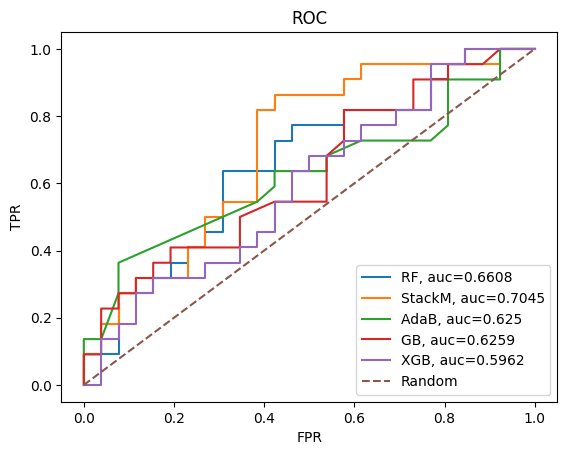

In [47]:
# predicted probabilities generated by models
y_pred_probaStack = stackingCLF.predict_proba(X_test)  # stacking
y_pred_probaRF = bagmodel_tuned.predict_proba(X_test)  # RF
y_pred_probaAdB = AdaBoost_tuned.predict_proba(X_test)  # AdaBoost
y_pred_probaGb = GB_tuned.predict_proba(X_test)  # GradBoost
y_pred_probaXGB = XGB_tuned.predict_proba(X_test)  # XGBoost

# Temp
y_pred_probaRF_prob = y_pred_probaRF[:,1]

# Stacking ROC dependencies
fpr, tpr, _ = roc_curve(y_test, y_pred_probaStack[:, 1])
auc = round(roc_auc_score(y_test, y_pred_probaStack[:, 1]), 4)

# RF ROC dependencies
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_probaRF_prob)
auc_RF = round(roc_auc_score(y_test, y_pred_probaRF_prob), 4)

# AdaBoost ROC dependencies
fpr_AB, tpr_AB, _ = roc_curve(y_test, y_pred_probaAdB[:, 1])
auc_AB = round(roc_auc_score(y_test, y_pred_probaAdB[:, 1]), 4)

# Gradient Boost ROC dependencies
fpr_GB, tpr_GB, _ = roc_curve(y_test, y_pred_probaGb[:, 1])
auc_GB = round(roc_auc_score(y_test, y_pred_probaGb[:, 1]), 4)

# XGB ROC dependencies
fpr_XGB, tpr_XGB, _ = roc_curve(y_test, y_pred_probaXGB[:, 1])
auc_XGB = round(roc_auc_score(y_test, y_pred_probaXGB[:, 1]), 4)

# RF Model
plt.plot(fpr_RF, tpr_RF, label="RF, auc=" + str(auc_RF))
# Stacking Model
plt.plot(fpr, tpr, label="StackM, auc=" + str(auc))
# AdaBoost Model
plt.plot(fpr_AB, tpr_AB, label="AdaB, auc=" + str(auc_AB))
# `GradBoost` Model
plt.plot(fpr_GB, tpr_GB, label="GB, auc=" + str(auc_GB))
# XGBoost Model
plt.plot(fpr_XGB, tpr_XGB, label="XGB, auc=" + str(auc_XGB))

# Random guess model
plt.plot(fpr, fpr, "--", label="Random")
plt.title("ROC")
plt.ylabel("TPR")
plt.xlabel("FPR")

plt.legend(loc=4)
plt.show()

In [48]:
!jupyter nbconvert --to html GWP3_MScFE632_StudentGroup2722.ipynb

[NbConvertApp] Converting notebook GWP3_MScFE632_StudentGroup2722.ipynb to html
[NbConvertApp] Writing 896037 bytes to GWP3_MScFE632_StudentGroup2722.html
